In [1]:
!pip install biopython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 600
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm
import matplotlib.colors as colors
from Bio import SeqIO
from Bio import pairwise2
from Bio.Align import substitution_matrices

/usr/local/lib/python3.8/dist-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


In [3]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# The log2 fold-changes previously computed for each paralog pair are uploaded
couples_divergence = pd.read_csv('/content/drive/My Drive/Redaction_SA/Figures_2021_06/Data_sim_ready/couples_divergence.csv')

In [5]:
# A new dataframe is made and divergence ratios are computed
ratios_pairs = couples_divergence[['Duplication', 'ORF_P1', 'Gene_P1', 'ORF_P2', 'Gene_P2',
                                   'bm_P1', 'bm_P2', 'bp_P1', 'bp_P2', 'bm_fold_original',
                                   'bp_fold_original', 'pEst_fold_original']].copy()

ratios_pairs['Div_ratio'] = np.log2((2**ratios_pairs['bm_fold_original']) / (2**ratios_pairs['bp_fold_original']))

## 1) Measuring functional divergence as the correlation of genetic interaction profiles

The similarity matrix is downloaded from https://thecellmap.org/costanzo2016/ (December 17th, 2021)

In [6]:
sim_all = pd.read_table('/content/drive/My Drive/Redaction_SA/Stat_analysis/cc_ALL.txt')

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,2

In [7]:
sim_all

,Unnamed: 0,Unnamed: 1,aac1,aac3,aad10,aad14,aad15,aad16,aad3,aad4,...,zpr1-1,zrc1,zrg17,zrg8,zrt1,zrt2,zrt3,zta1,zuo1,zwf1
0,NaN,NaN,YMR056C,YBR085W,YJR155W,YNL331C,YOL165C,YFL057C,YCR107W,YDL243C,...,YGR211W,YMR243C,YNR039C,YER033C,YGL255W,YLR130C,YKL175W,YBR046C,YGR285C,YNL241C
1,aac1,YMR056C,NaN,0.01251,-0.03251,0.02980,0.00285,-0.02194,0.00522,-0.04020,...,-0.01962,-0.04248,-0.02933,0.16635,-0.01719,0.02141,-0.01459,0.01380,0.08979,-0.04379
2,aac3,YBR085W,0.01251,0.00262,0.10133,0.01135,0.00874,0.01328,-0.02565,0.05683,...,-0.01788,-0.01501,-0.01821,0.00379,-0.02661,0.01059,0.02074,0.02762,0.01383,-0.00223
3,aad10,YJR155W,-0.03251,0.10133,0.00262,0.02275,0.09555,0.00593,0.00104,0.02994,...,0.00997,0.00495,0.01329,-0.00238,-0.00996,0.03451,0.04072,-0.01962,0.03401,0.02546
4,aad14,YNL331C,0.02980,0.01135,0.02275,0.00262,0.09629,-0.01614,0.00571,0.04171,...,0.01528,-0.01605,0.00214,-0.00263,0.02580,-0.02574,-0.01501,-0.01131,-0.01969,-0.01028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6226,zrt2,YLR130C,0.02141,0.01059,0.03451,-0.02574,-0.0105,0.06777,0.00947,0.02731,...,0.01618,0.04231,0.00953,0.09629,-0.0995,NaN,-0.01663,0.01201,-0.04455,-0.03448
6227,zrt3,YKL175W,-0.01459,0.02074,0.04072,-0.01501,0.03166,-0.01572,-0.01154,-0.01202,...,0.03731,0.00949,0.01814,-0.08212,0.00724,-0.01663,NaN,0.0149,-0.10156,-0.00132
6228,zta1,YBR046C,0.0138,0.02762,-0.01962,-0.01131,0.0284,0.06585,-0.02575,0.0195,...,-0.01104,0.02102,0.03907,0.0134,0.03217,0.01201,0.0149,NaN,-0.02169,-0.01898
6229,zuo1,YGR285C,0.08979,0.01383,0.03401,-0.01969,-0.00643,-0.01839,-0.00272,-0.01302,...,-0.04877,-0.01494,-0.03019,0.01921,0.00047,-0.04455,-0.10156,-0.02169,0.00262,0.05787


In [8]:
col_names = sim_all.iloc[0, :].copy()
sim_all.iloc[0, :] = sim_all.columns
col_names[0] = 'Allele'
col_names[1] = 'ORF'
sim_all.columns = col_names

In [9]:
sim_all.columns.unique()

Index(['Allele', 'ORF', 'YMR056C', 'YBR085W', 'YJR155W', 'YNL331C', 'YOL165C',
       'YFL057C', 'YCR107W', 'YDL243C',
       ...
       'YGR211W', 'YMR243C', 'YNR039C', 'YER033C', 'YGL255W', 'YLR130C',
       'YKL175W', 'YBR046C', 'YGR285C', 'YNL241C'],
      dtype='object', name=0, length=5709)

There are more than one mutant for some genes, so we need to count them.

In [10]:
mut_count = pd.DataFrame()
mut_count['ORF'] = sim_all['ORF'][1:]
mut_count['count'] = 1

mut_count = mut_count.groupby('ORF', as_index=False).sum()

The number of unique mutants for each studied paralog is added to the ratios_pairs dataframe

In [11]:
ratios_pairs['n_P1'] = np.NaN
ratios_pairs['n_P2'] = np.NaN

In [12]:
for row in range(ratios_pairs.shape[0]):

  P1 = ratios_pairs.at[row, 'ORF_P1']
  P2 = ratios_pairs.at[row, 'ORF_P2']

  vals_P1 = mut_count[mut_count['ORF'] == P1]['count'].values
  vals_P2 = mut_count[mut_count['ORF'] == P2]['count'].values

  if vals_P1.shape[0] != 0:
      ratios_pairs.at[row, 'n_P1'] = vals_P1[0]

  else:
    ratios_pairs.at[row, 'n_P1'] = np.NaN

  if vals_P2.shape[0] != 0:
    ratios_pairs.at[row, 'n_P2'] = vals_P2[0]

  else:
    ratios_pairs.at[row, 'n_P2'] = np.NaN

The genes for which more than one mutant are available are isolated

In [13]:
int_many = ratios_pairs[(ratios_pairs['n_P1'] > 1) | (ratios_pairs['n_P2'] > 1)].copy().reset_index(drop=True)

Genes with more than one mutant seem to be the ones for which a deletion is lethal or associated with a severe growth defect. 

For all three datasets, only gene pairs for which both paralogs were included in the AllxAll genetic interactions screen are kept

In [14]:
ratios_pairs = ratios_pairs.dropna(subset=['n_P1', 'n_P2']).reset_index(drop=True)

In [15]:
ratios_pairs

,Duplication,ORF_P1,Gene_P1,ORF_P2,Gene_P2,bm_P1,bm_P2,bp_P1,bp_P2,bm_fold_original,bp_fold_original,pEst_fold_original,Div_ratio,n_P1,n_P2
0,SSD,YAL036C,RBG1,YGR173W,RBG2,1.718675,1.643553,3.092909,3.097578,0.249550,0.015510,0.234040,0.234040,1.0,1.0
1,SSD,YAL039C,CYC3,YKL087C,CYT2,0.891671,1.082354,3.449659,3.456405,0.633434,0.022409,0.655843,0.611024,1.0,1.0
2,SSD,YAL042W,ERV46,YML067C,ERV41,1.970836,1.617977,2.782261,2.991756,1.172172,0.695928,0.476245,0.476245,1.0,1.0
3,SSD,YAL060W,BDH1,YAL061W,BDH2,1.823724,0.887096,2.972863,3.073859,3.111409,0.335500,2.775910,2.775910,1.0,1.0
4,SSD,YBL011W,SCT1,YKR067W,GPT2,1.485945,1.290915,2.267457,2.498851,0.647877,0.768674,0.120797,-0.120797,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,WGD,YCL043C,PDI1,YDR518W,EUG1,2.522175,1.411950,2.903163,2.876385,3.688088,0.088956,3.777045,3.599132,1.0,1.0
373,WGD,YIL135C,VHS2,YNL074C,MLF3,1.082863,1.264818,2.931731,2.957714,0.604439,0.086313,0.690751,0.518126,1.0,1.0
374,WGD,YMR177W,MMT1,YPL224C,MMT2,0.959662,1.090190,2.711851,2.656638,0.433605,0.183414,0.250190,0.250190,1.0,1.0
375,WGD,YOR237W,HES1,YPL145C,KES1,0.238656,1.932001,2.694922,2.939815,5.625170,0.813515,6.438685,4.811654,1.0,1.0


Mean similarity scores (per ORF) are computed:

In [16]:
sim_all = sim_all.iloc[1:, 1:]

In [17]:
# Change dtype to float
num_col = {}

num_col['ORF'] = 'string'

for gene in sim_all.columns[1:]:
  num_col[gene] = 'float64'

sim_all = sim_all.astype(num_col)

In [18]:
# So that data can be aggregated both by columns and by rows, the ORF column is
# set as index
sim_all.index = sim_all.iloc[:, 0]
sim_all = sim_all.iloc[0:, 1:]

# Aggregating by columns
sim_all = sim_all.groupby(by=sim_all.columns, axis=1).mean()

# Aggregating by rows
sim_all = sim_all.groupby(by=sim_all.index).mean()

The similarity coefficients (Pearson correlations) are added to the dataframes of duplicate pairs relative divergence

In [19]:
ratios_pairs['Profile_sim'] = np.NaN

for row in range(ratios_pairs.shape[0]):

  P1 = ratios_pairs.at[row, 'ORF_P1']
  P2 = ratios_pairs.at[row, 'ORF_P2']

  ratios_pairs.at[row, 'Profile_sim'] = sim_all.loc[P1, P2]

Finally, the absolute value of the similarity coefficient is computed in each case, as we are only interested in their magnitude.

In [20]:
#ratios_pairs['Profile_sim'] = np.absolute(ratios_pairs['Profile_sim'])

## 2) Functional divergence as GO overlap

SGD's GO Slim are used. The file go_slim_mapping.tab was downloaded from http://sgd-archive.yeastgenome.org/curation/literature/. File version: 2021-10-27T19:44:41.000Z 

In [21]:
go_slim = pd.read_table('/content/drive/My Drive/Redaction_SA/Stat_analysis/go_slim_mapping.tab',
                        header=None, names=['ORF', 'Gene', 'SGD_ID', 'GO_Aspect',
                                              'GO_slim_term', 'GOID', 'Feature_type'])

A new dataframe is created, in which the Jaccard index of GO terms at each ontology level (Process, Function, Component), as well as for all in common, will be computed for every paralog pair:

In [22]:
GO_pairs = pd.DataFrame(columns=['Duplication', 'ORF_P1', 'Gene_P1', 'ORF_P2',
                                 'Gene_P2', 'bm_fold_original', 'bp_fold_original',
                                 'pEst_fold_original', 'Div_ratio', 
                                 'Jaccard_process', 'Jaccard_function',
                                 'Jaccard_component', 'Jaccard_all',
                                 'unique_process', 'common_process', 'unique_function',
                                 'common_function', 'unique_component',
                                 'common_component', 'unique_all', 'common_all'])

GO_pairs[['Duplication', 'ORF_P1', 'Gene_P1', 'ORF_P2', 'Gene_P2',
          'bm_fold_original', 'bp_fold_original', 'pEst_fold_original']] = couples_divergence[['Duplication', 'ORF_P1', 'Gene_P1', 'ORF_P2', 'Gene_P2','bm_fold_original',
                                                                                               'bp_fold_original', 'pEst_fold_original']].copy()

GO_pairs['Div_ratio'] = np.log2((2**GO_pairs['bm_fold_original']) / (2**GO_pairs['bp_fold_original']))

All the Jaccard indexes are computed iteratively

In [23]:
for row in range(GO_pairs.shape[0]):
  P1 = GO_pairs.at[row, 'ORF_P1']
  P2 = GO_pairs.at[row, 'ORF_P2']

  P1_subset = go_slim[go_slim['ORF'] == P1].copy().reset_index(drop=True)
  P2_subset = go_slim[go_slim['ORF'] == P2].copy().reset_index(drop=True)

  process_P1 = set(P1_subset[P1_subset['GO_Aspect'] == 'P']['GOID'].unique())
  function_P1 = set(P1_subset[P1_subset['GO_Aspect'] == 'F']['GOID'].unique())
  component_P1 = set(P1_subset[P1_subset['GO_Aspect'] == 'C']['GOID'].unique())
  all_P1 = process_P1 | function_P1 | component_P1

  process_P2 = set(P2_subset[P2_subset['GO_Aspect'] == 'P']['GOID'].unique())
  function_P2 = set(P2_subset[P2_subset['GO_Aspect'] == 'F']['GOID'].unique())
  component_P2 = set(P2_subset[P2_subset['GO_Aspect'] == 'C']['GOID'].unique())
  all_P2 = process_P2 | function_P2 | component_P2

  int_process = process_P1 & process_P2
  int_function = function_P1 & function_P2
  int_component = component_P1 & component_P2
  int_all = all_P1 & all_P2

  union_process = process_P1 | process_P2
  union_function = function_P1 | function_P2
  union_component = component_P1 | component_P2
  union_all = all_P1 | all_P2

  if len(union_process) > 0:
    GO_pairs.at[row, 'Jaccard_process'] = len(int_process) / len(union_process)

  else:
    GO_pairs.at[row, 'Jaccard_process'] = np.NaN

  if len(union_function) > 0:
    GO_pairs.at[row, 'Jaccard_function'] = len(int_function) / len(union_function)

  else:
    GO_pairs.at[row, 'Jaccard_function'] = np.NaN

  if len(union_component) > 0:
    GO_pairs.at[row, 'Jaccard_component'] = len(int_component) / len(union_component)

  else:
    GO_pairs.at[row, 'Jaccard_component'] = np.NaN

  if len(union_all) > 0:
    GO_pairs.at[row, 'Jaccard_all'] = len(int_all) / len(union_all)

  else:
    GO_pairs.at[row, 'Jaccard_all'] = np.NaN

  GO_pairs.at[row, 'unique_process'] = len(union_process)
  GO_pairs.at[row, 'common_process'] = len(int_process)

  GO_pairs.at[row, 'unique_function'] = len(union_function)
  GO_pairs.at[row, 'common_function'] = len(int_function)

  GO_pairs.at[row, 'unique_component'] = len(union_component)
  GO_pairs.at[row, 'common_component'] = len(int_component)

  GO_pairs.at[row, 'unique_all'] = len(union_all)
  GO_pairs.at[row, 'common_all'] = len(int_all)

The distributions of Jaccard indexes at the four levels are compared, to identify the one which seems to contain the most information

Text(0.5, 0, 'Jaccard_index')

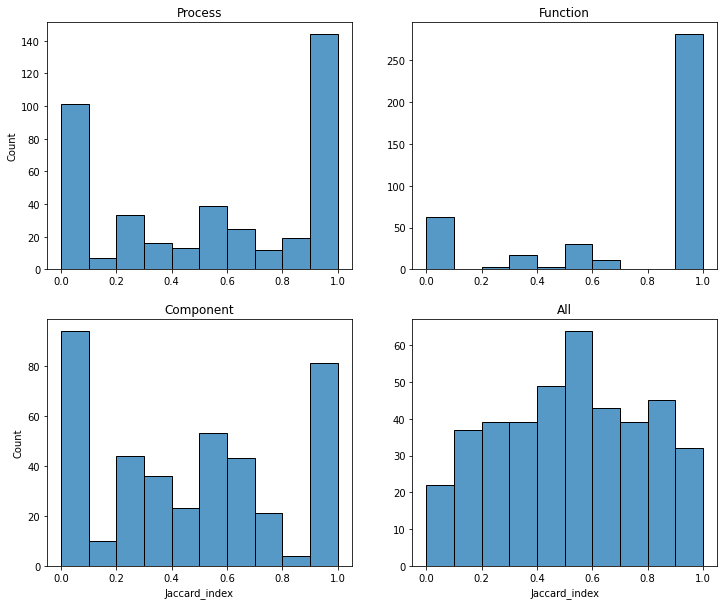

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(data=GO_pairs, x='Jaccard_process', ax=axs[0,0])
sns.histplot(data=GO_pairs, x='Jaccard_function', ax=axs[0,1])
sns.histplot(data=GO_pairs, x='Jaccard_component', ax=axs[1,0])
sns.histplot(data=GO_pairs, x='Jaccard_all', ax=axs[1,1])

axs[0,0].set_title('Process')
axs[0,1].set_title('Function')
axs[1,0].set_title('Component')
axs[1,1].set_title('All')

for ax in [axs[0,0], axs[0,1], axs[1,0], axs[1,1]]:
  ax.set_xlabel('')
  ax.set_ylabel('')

axs[0,0].set_ylabel('Count')
axs[1,0].set_ylabel('Count')

axs[1,0].set_xlabel('Jaccard_index')
axs[1,1].set_xlabel('Jaccard_index')

The combination of the three ontology levels ('All') will be used, as it seems to be the most informative.

## 3) Functional divergence as AA identity

The amino acid sequences of all yeast ORFs are dowloaded from SGD: http://sgd-archive.yeastgenome.org/sequence/S288C_reference/orf_protein/

Version of the file: 2021-04-22T22:49:47.000Z 

In [25]:
aa_dict = SeqIO.to_dict(SeqIO.parse('/content/drive/My Drive/Redaction_SA/Stat_analysis/orf_trans_all_R64-3-1_20210421.fasta', 
                                    'fasta'))

A new dataframe is made to compile identity percentages, and a pairwise (global) alignment of each paralog pair is done:

In [26]:
ident_pairs = pd.DataFrame(columns=['Duplication', 'ORF_P1', 'Gene_P1', 'ORF_P2',
                                    'Gene_P2', 'bm_fold_original', 'bp_fold_original',
                                    'pEst_fold_original', 'Div_ratio',
                                    'aa_identity'])

ident_pairs[['Duplication', 'ORF_P1', 'Gene_P1', 'ORF_P2', 'Gene_P2',
             'bm_fold_original', 'bp_fold_original', 'pEst_fold_original']] = couples_divergence[['Duplication', 'ORF_P1', 'Gene_P1', 'ORF_P2', 'Gene_P2','bm_fold_original',
                                                                                                  'bp_fold_original', 'pEst_fold_original']].copy()

ident_pairs['Div_ratio'] = np.log2((2**ident_pairs['bm_fold_original']) / (2**ident_pairs['bp_fold_original']))

In [27]:
#blosum62 = substitution_matrices.load("BLOSUM62") #loading identity matrix

#for row in range(ident_pairs.shape[0]):
  #P1 = ident_pairs.at[row, 'ORF_P1']
  #P2 = ident_pairs.at[row, 'ORF_P2']
  
  #seq1 = aa_dict[P1]
  #seq2 = aa_dict[P2]

  #alignment = pairwise2.align.globalds(seq1.seq, seq2.seq, blosum62, -10, -0.5,
                                       #one_alignment_only=True)
  
  #alignment = pairwise2.align.globaldx(seq1.seq, seq2.seq, blosum62,
                                       #one_alignment_only=True)

  # Next, compute identity percentage
  #seq1 = np.array(list(alignment[0].seqA))
  #seq2 = np.array(list(alignment[0].seqB))
  #ident = np.where(seq1 == seq2)
  #gaps_1 = np.where(seq1 == '-', 1, 0)
  #gaps_2 = np.where(seq2 == '-', 1, 0)
  #gaps_both = np.where(gaps_1 + gaps_2 == 2) # Should not happen, but just in case

  #percent = (ident[0].shape[0] - gaps_both[0].shape[0]) / (seq1.shape[0] - gaps_both[0].shape[0])

  #ident_pairs.at[row, 'aa_identity'] = percent

  #if row%10 == 0:
    #print(f'Done with pair {row}')
    #print(f'gaps_both = {gaps_both[0].shape[0]}')

#ident_pairs.to_csv('/content/drive/My Drive/Redaction_SA/Stat_analysis/aa_identity.csv', index=False)

#ident_pairs.to_csv('/content/drive/My Drive/Redaction_SA/Stat_analysis/aa_identity_nopenalty.csv', index=False)

In [28]:
id_aa_df = pd.read_csv('/content/drive/My Drive/Redaction_SA/Stat_analysis/aa_identity.csv')
id_aa_nopen = pd.read_csv('/content/drive/My Drive/Redaction_SA/Stat_analysis/aa_identity_nopenalty.csv')

How correlated are AA identities obtained from alignment with gap opening penalties and without?

Text(0.25, 0.65, 'r = 0.989\np-val = 0.000e+00')

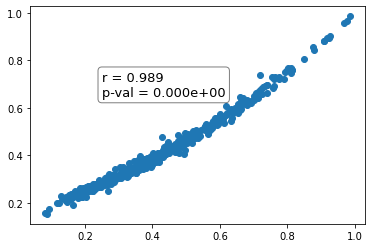

In [29]:
plt.scatter(id_aa_df['aa_identity'], id_aa_nopen['aa_identity'])

r_align = stats.pearsonr(id_aa_df['aa_identity'], id_aa_nopen['aa_identity'])

plt.annotate(r"r = " f'{round(r_align[0], 3)}\np-val = {r_align[1]:.3e}',
                (0.25, 0.65), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
             fontsize=13)

They are very well correlated! Is the panel of correlations with AA identity different depending on the aligments used?

Text(0.25, 7, '$\\rho$ = 0.043\np-val = 3.903e-01')

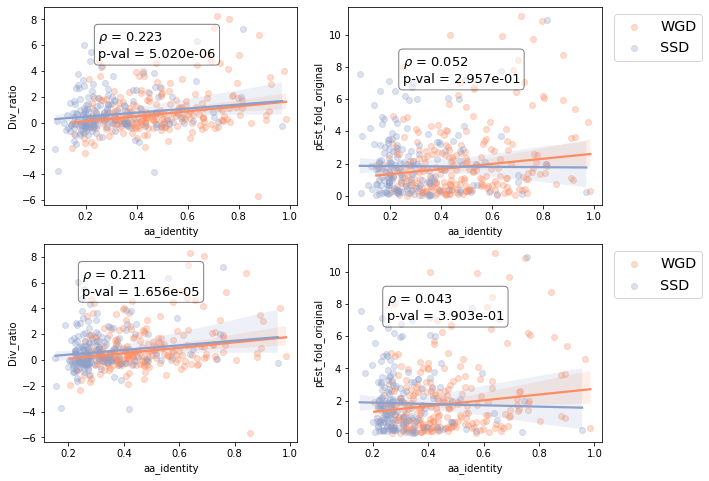

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# First with gap penalties
sns.regplot(x='aa_identity', y='Div_ratio', 
            data=id_aa_df[id_aa_df['Duplication'] == 'WGD'], 
            ax=axs[0,0], color=cm.Set2.colors[1],
            scatter_kws={'alpha':0.3}, robust=True,
            label='WGD')

sns.regplot(x='aa_identity', y='Div_ratio', 
            data=id_aa_df[id_aa_df['Duplication'] == 'SSD'], 
            ax=axs[0,0], color=cm.Set2.colors[2],
            scatter_kws={'alpha':0.3}, robust=True,
            label='SSD')

sns.regplot(x='aa_identity', y='pEst_fold_original',
            data=id_aa_df[id_aa_df['Duplication'] == 'WGD'],
            ax=axs[0,1], color=cm.Set2.colors[1],
            scatter_kws={'alpha':0.3},
            label='WGD', robust=True)

sns.regplot(x='aa_identity', y='pEst_fold_original',
            data=id_aa_df[id_aa_df['Duplication'] == 'SSD'],
            ax=axs[0,1], color=cm.Set2.colors[2],
            scatter_kws={'alpha':0.3},
            label='SSD', robust=True)

axs[0,1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='x-large')

# Addition of the corresponding correlation coefficients and p-values
rho_ratio = stats.spearmanr(id_aa_df['aa_identity'], 
                            id_aa_df['Div_ratio'])

axs[0,0].annotate(r"$\rho$ = " f'{round(rho_ratio[0], 3)}\np-val = {rho_ratio[1]:.3e}',
                (0.25, 5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=13)

rho_div = stats.spearmanr(id_aa_df['aa_identity'], 
                          id_aa_df['pEst_fold_original'])

axs[0,1].annotate(r"$\rho$ = " f'{round(rho_div[0], 3)}\np-val = {rho_div[1]:.3e}',
                (0.25, 7), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=13)

# Second, without gap penalties
sns.regplot(x='aa_identity', y='Div_ratio', 
            data=id_aa_nopen[id_aa_nopen['Duplication'] == 'WGD'], 
            ax=axs[1,0], color=cm.Set2.colors[1],
            scatter_kws={'alpha':0.3}, robust=True,
            label='WGD')

sns.regplot(x='aa_identity', y='Div_ratio', 
            data=id_aa_nopen[id_aa_nopen['Duplication'] == 'SSD'], 
            ax=axs[1,0], color=cm.Set2.colors[2],
            scatter_kws={'alpha':0.3}, robust=True,
            label='SSD')

sns.regplot(x='aa_identity', y='pEst_fold_original',
            data=id_aa_nopen[id_aa_nopen['Duplication'] == 'WGD'],
            ax=axs[1,1], color=cm.Set2.colors[1],
            scatter_kws={'alpha':0.3},
            label='WGD', robust=True)

sns.regplot(x='aa_identity', y='pEst_fold_original',
            data=id_aa_nopen[id_aa_nopen['Duplication'] == 'SSD'],
            ax=axs[1,1], color=cm.Set2.colors[2],
            scatter_kws={'alpha':0.3},
            label='SSD', robust=True)

axs[1,1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='x-large')

# Addition of the corresponding correlation coefficients and p-values
rho_ratio = stats.spearmanr(id_aa_nopen['aa_identity'], 
                            id_aa_nopen['Div_ratio'])

axs[1,0].annotate(r"$\rho$ = " f'{round(rho_ratio[0], 3)}\np-val = {rho_ratio[1]:.3e}',
                (0.25, 5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=13)

rho_div = stats.spearmanr(id_aa_nopen['aa_identity'], 
                          id_aa_nopen['pEst_fold_original'])

axs[1,1].annotate(r"$\rho$ = " f'{round(rho_div[0], 3)}\np-val = {rho_div[1]:.3e}',
                (0.25, 7), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=13)

There are almost no differences. The identity percentages obtained from aligments using gap penalties will be used for the Fig S5:

## 4) Construction of the figure

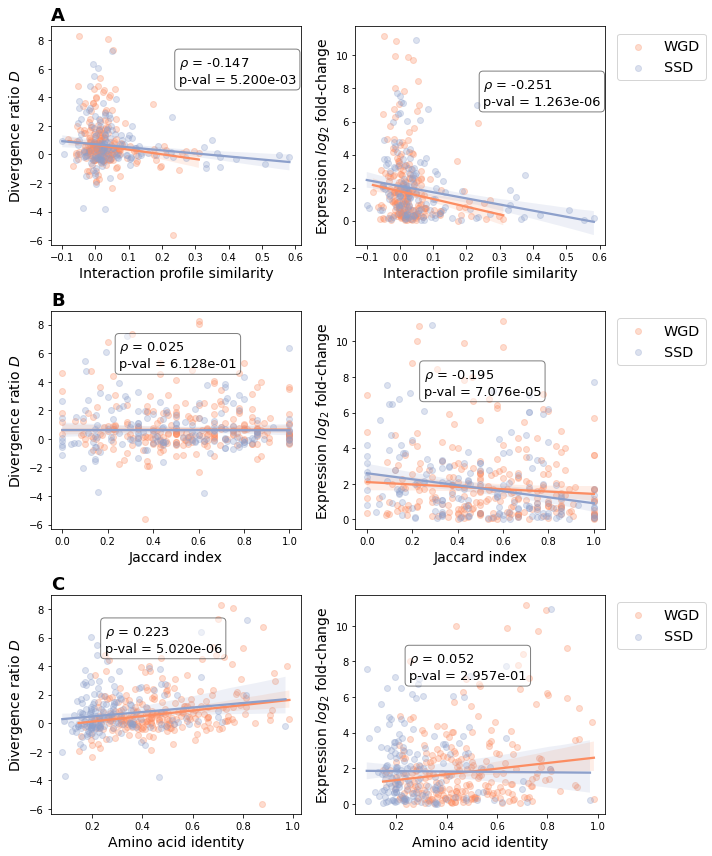

In [31]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12))

# Subfigure A
ratios_pairs = ratios_pairs.dropna(subset=['Profile_sim']).reset_index(drop=True)

sns.regplot(x='Profile_sim', y='Div_ratio', 
            data=ratios_pairs[ratios_pairs['Duplication'] == 'WGD'], 
            ax=axs[0,0], color=cm.Set2.colors[1],
            scatter_kws={'alpha':0.3}, robust=True, label='WGD')

sns.regplot(x='Profile_sim', y='Div_ratio', 
            data=ratios_pairs[ratios_pairs['Duplication'] == 'SSD'], 
            ax=axs[0,0], color=cm.Set2.colors[2], scatter_kws={'alpha':0.3},
            robust=True, label='SSD')

sns.regplot(x='Profile_sim', y='pEst_fold_original',
            data=ratios_pairs[ratios_pairs['Duplication'] == 'WGD'],
            ax=axs[0,1], color=cm.Set2.colors[1], scatter_kws={'alpha':0.3},
            label='WGD', robust=True)

sns.regplot(x='Profile_sim', y='pEst_fold_original',
            data=ratios_pairs[ratios_pairs['Duplication'] == 'SSD'],
            ax=axs[0,1], color=cm.Set2.colors[2], scatter_kws={'alpha':0.3},
            label='SSD', robust=True)

axs[0,1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='x-large')

# Addition of the corresponding correlations and p-values
rho_ratio = stats.spearmanr(ratios_pairs['Profile_sim'], 
                            ratios_pairs['Div_ratio'])

axs[0,0].annotate(r"$\rho$ = " f'{round(rho_ratio[0], 3)}\np-val = {rho_ratio[1]:.3e}',
                (0.25, 5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=13)

rho_div = stats.spearmanr(ratios_pairs['Profile_sim'], 
                            ratios_pairs['pEst_fold_original'])

axs[0,1].annotate(r"$\rho$ = " f'{round(rho_div[0], 3)}\np-val = {rho_div[1]:.3e}',
                (0.25, 7), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=13)

# Subfigure B
GO_pairs_ready = GO_pairs.dropna(subset=['Jaccard_all']).reset_index(drop=True)
GO_pairs_ready = GO_pairs_ready.infer_objects()

sns.regplot(x='Jaccard_all', y='Div_ratio', 
            data=GO_pairs_ready[GO_pairs_ready['Duplication'] == 'WGD'], 
            ax=axs[1,0], color=cm.Set2.colors[1],
            scatter_kws={'alpha':0.3}, robust=True,
            label='WGD')

sns.regplot(x='Jaccard_all', y='Div_ratio', 
            data=GO_pairs_ready[GO_pairs_ready['Duplication'] == 'SSD'], 
            ax=axs[1,0], color=cm.Set2.colors[2],
            scatter_kws={'alpha':0.3}, robust=True,
            label='SSD')

sns.regplot(x='Jaccard_all', y='pEst_fold_original',
            data=GO_pairs_ready[GO_pairs_ready['Duplication'] == 'WGD'],
            ax=axs[1,1], color=cm.Set2.colors[1], scatter_kws={'alpha':0.3},
            label='WGD', robust=True)

sns.regplot(x='Jaccard_all', y='pEst_fold_original',
            data=GO_pairs_ready[GO_pairs_ready['Duplication'] == 'SSD'],
            ax=axs[1,1], color=cm.Set2.colors[2], scatter_kws={'alpha':0.3},
            label='SSD', robust=True)

axs[1,1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='x-large')

# Addition of the corresponding correlations and p-values
rho_ratio = stats.spearmanr(GO_pairs_ready['Jaccard_all'], 
                            GO_pairs_ready['Div_ratio'])

axs[1,0].annotate(r"$\rho$ = " f'{round(rho_ratio[0], 3)}\np-val = {rho_ratio[1]:.3e}',
                (0.25, 5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=13)

rho_div = stats.spearmanr(GO_pairs_ready['Jaccard_all'], 
                          GO_pairs_ready['pEst_fold_original'])

axs[1,1].annotate(r"$\rho$ = " f'{round(rho_div[0], 3)}\np-val = {rho_div[1]:.3e}',
                (0.25, 7), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=13)

# Subfigure C
sns.regplot(x='aa_identity', y='Div_ratio', 
            data=id_aa_df[id_aa_df['Duplication'] == 'WGD'], 
            ax=axs[2,0], color=cm.Set2.colors[1],
            scatter_kws={'alpha':0.3}, robust=True,
            label='WGD')

sns.regplot(x='aa_identity', y='Div_ratio', 
            data=id_aa_df[id_aa_df['Duplication'] == 'SSD'], 
            ax=axs[2,0], color=cm.Set2.colors[2],
            scatter_kws={'alpha':0.3}, robust=True,
            label='SSD')

sns.regplot(x='aa_identity', y='pEst_fold_original',
            data=id_aa_df[id_aa_df['Duplication'] == 'WGD'],
            ax=axs[2,1], color=cm.Set2.colors[1],
            scatter_kws={'alpha':0.3},
            label='WGD', robust=True)

sns.regplot(x='aa_identity', y='pEst_fold_original',
            data=id_aa_df[id_aa_df['Duplication'] == 'SSD'],
            ax=axs[2,1], color=cm.Set2.colors[2],
            scatter_kws={'alpha':0.3},
            label='SSD', robust=True)

axs[2,1].legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='x-large')

# Addition of the corresponding correlation coefficients and p-values
rho_ratio = stats.spearmanr(id_aa_df['aa_identity'], 
                            id_aa_df['Div_ratio'])

axs[2,0].annotate(r"$\rho$ = " f'{round(rho_ratio[0], 3)}\np-val = {rho_ratio[1]:.3e}',
                (0.25, 5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=13)

rho_div = stats.spearmanr(id_aa_df['aa_identity'], 
                          id_aa_df['pEst_fold_original'])

axs[2,1].annotate(r"$\rho$ = " f'{round(rho_div[0], 3)}\np-val = {rho_div[1]:.3e}',
                (0.25, 7), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=13)

# Axes labels
for ax in [axs[0,0], axs[1,0], axs[2,0]]:
  ax.set_ylabel(r"Divergence ratio $D$", fontsize=14)

for ax in [axs[0,1], axs[1,1], axs[2,1]]:
  ax.set_ylabel(r"Expression $log_2$ fold-change", fontsize=14)

axs[0,0].set_xlabel('Interaction profile similarity', fontsize=14)
axs[1,0].set_xlabel('Jaccard index', fontsize=14)
axs[2,0].set_xlabel('Amino acid identity', fontsize=14)

axs[0,1].set_xlabel('Interaction profile similarity', fontsize=14)
axs[1,1].set_xlabel('Jaccard index', fontsize=14)
axs[2,1].set_xlabel('Amino acid identity', fontsize=14)

axs[0,0].set_title('A', loc='left', fontsize=18, fontweight="bold")
axs[1,0].set_title('B', loc='left', fontsize=18, fontweight="bold")
axs[2,0].set_title('C', loc='left', fontsize=18, fontweight="bold")

plt.tight_layout()

FigS2 = plt.gcf()
#FigS2.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/FigS5.pdf', bbox_inches='tight')
FigS2.savefig('/content/drive/My Drive/Redaction_SA/Final_figures_v2/FigS5.tiff', bbox_inches='tight')